# ECE 285 Final Project: Facial Expression Recognition
#### By Shivani Bhakta and Payal Singh 

# Preparation

In [1]:
import numpy as np
import glob
from PIL import Image
from PIL import Image, ImageOps
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt



from torch.utils.data import Dataset
import os
import os.path as osp
import cv2 
import sys
import copy
from woodnet import *

## Crop and resize Images
- We use MTCNN face detector to recognize face in our dataset and crop each images and resize them to 224 x 224.
- We resize and then store them into a new folder
- https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch

####### TO DO THIS #########
- Run the PrepData.py file. Can use the command ``` python PrepData.py``` in terminal

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Tufts Face DB 
In this project we use a dataset named Tufts Face Database for Facial Recognition. This dataset is made up with over 10,000 images of 74 female and 38 males from more than 15 countried with the age range between 4-70 years old. This dataset contains 7 image modalities, but we only use a subset of it, from the Tufts Face Databse 2D RGB Expression (TDRGBA). This set contains 5 images of 50 different people. These 5 images are of 5 different expression. 

## Visualize the dataset

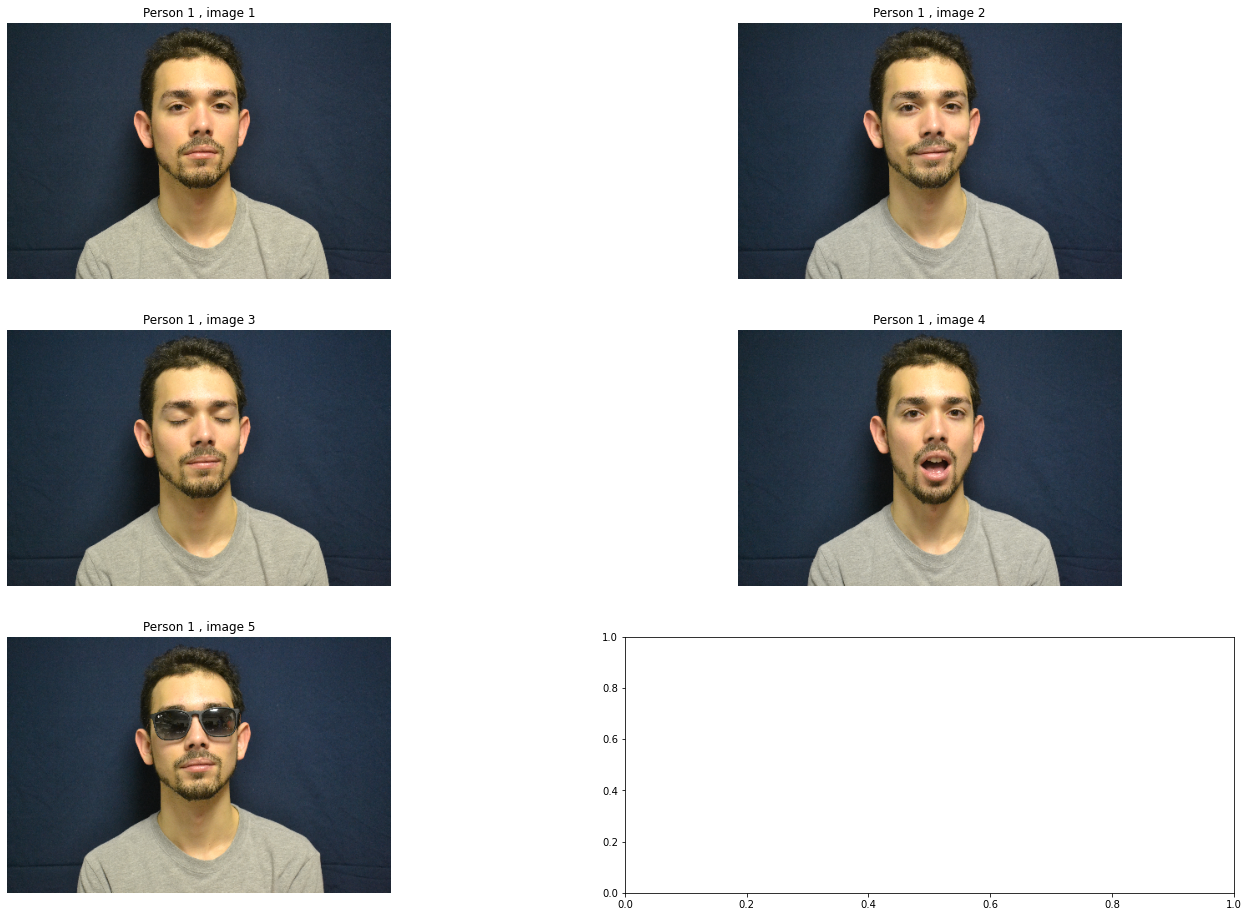

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# import PI

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))
for person in range(1, 51): 
    if person == 47: continue
    for idx in range(1,6):
        t = 'dataset/' + str(person) + '/TD_RGB_E_{}.jpg'.format(idx)

        im = Image.open(t)
        width, height = im.size #3072,4608

        newsize = (width//10, height//10)
        im2 = im.resize(newsize) # resized Image Size:  (460, 307)
    
        fn = 'TD_RGB_E_{}_{}.jpg'.format(person,idx)
        im2.save('dataset/resized/' + fn)
    
        if person == 1: 
            # Display the first person's all images
            if idx in [1,2]: 
                i = 0
                j = idx - 1

            elif idx in [3,4]:
                i = 1
                j = idx - 3    
            else: 
                i = 2
                j = idx - 5 
            axes[i][j].axis('off')
            axes[i][j].imshow(im2)
            axes[i][j].set_title('Person 1 , image {}'.format(idx))
#             print("resized Image Size: ", im2.size)

# Dataloader

In [17]:
def get_faces():
    '''
    input: 
        n: number of images to load from the folder. 
    output: 
        neutral_faces: numpy array with each column corresponds to a data point(each image of neutral faces) 
        smiling_faces: numpy array with each column corresponds to a data point(each image of smiling faces)
    '''
    n = 49    # will change when do data augmentation
    
    neutral_faces = np.zeros((n,3,224,224))
    smiling_faces = np.zeros((n,3,224,224))
    eyesclosed_faces = np.zeros((n,3,224,224))
    surprised_faces = np.zeros((n,3,224,224))
    sunglasses_faces = np.zeros((n,3,224,224))

    for i in range(1,n+1):
        if i == 47: continue     
        path = str('cropped/')
            
        for j in range(1,6):
            image_path = path + 'TD_RGB_E_{}_{}.jpg'.format(i,j)
            p = Image.open(image_path)        
            p = np.transpose(np.array(p))
        
            if j == 1: neutral_faces[i-1,:] = p
            elif j == 2: smiling_faces[i-1,:] = p
            elif j ==3: eyesclosed_faces[i-1,:] = p
            elif j == 4: surprised_faces[i-1,:] = p
            elif j == 5: sunglasses_faces[i-1,:] = p

#     return np.transpose(neutral_faces), np.transpose(smiling_faces), np.transpose(eyesclosed_faces), np.transpose(surprised_faces), np.transpose(sunglasses_faces)
    return neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces

neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces = get_faces()
print(neutral_faces.shape)

(49, 3, 224, 224)


In [18]:
# dataset
data = np.vstack((neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces))
labels_0 = [0] * len(neutral_faces)
labels_1 = [1] * len(neutral_faces)
labels_2 = [2] * len(neutral_faces)
labels_3 = [3] * len(neutral_faces)
labels_4 = [4] * len(neutral_faces)

labels = labels_0 + labels_1 + labels_2 + labels_3 + labels_4
labels = np.array(labels)
idxs = list(range(245))   # will change when do data augmentation
np.random.shuffle(idxs)

data = data[idxs]
labels = labels[idxs]
print("Total data shape: ", data.shape)

test_train_split = 0.88889
train_data = data[:int(test_train_split * len(idxs))]
train_labels = labels[:int(test_train_split * len(idxs))]
print("Train data shape: ", train_data.shape)

test_data = data[int(test_train_split * len(idxs)):]
test_labels = labels[int(test_train_split * len(idxs)):]
print("Train data shape: ", train_data.shape)

image = test_data[0]
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print("Individual Image size: ", image.shape)

Total data shape:  (245, 3, 224, 224)
Train data shape:  (217, 3, 224, 224)
Train data shape:  (217, 3, 224, 224)
Individual Image size:  (1, 3, 224, 224)


In [19]:
class MyDataset(Dataset):
    ''' This class formats the dataset into a iterable-style dataset needed for the dataloader '''
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        data = {'x': x, 'y': y}
        return data
    
    def __len__(self):
        return len(self.data)

# trans = [T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
train_data = MyDataset(train_data, train_labels)
test_data = MyDataset(test_data, test_labels)
# dataloader = DataLoader(dataset, batch_size=5)

# Model 

#### Create a function to check the accuracy 

In [54]:
NUM_TRAIN = len(train_data)
NUM_TEST = len(test_data)

def check_accuracy(loader, model):
  
    num_correct = 0
    num_samples = 0
    loss = 0.00
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for data in loader:
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            loss = F.cross_entropy(scores,y) + loss
            
        acc = float(num_correct) / num_samples
        loss = loss/ num_samples
        
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
        return acc, loss

#### Create a function for training and validation 

In [59]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model lol
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_arr = []
    test_loss_arr = []
    test_acc_arr =[]
    model = model.to(device=device)  # move the model parameters to CPU/GPU
  
    for e in range(epochs):
        model.train() # put model to training mode
        for t, data in enumerate(loader_train):
            x = data['x'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = data['y'].to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            if t == 0:
                iter_loss = loss.item()
            else:
                iter_loss = iter_loss + loss.item()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
#                 acc_Val, loss_Val = check_accuracy(loader_val, model)
#                 print()
        loss_arr.append(iter_loss/t)
    
        model.eval()
        acc_Val, loss_Val = check_accuracy(loader_test, model)
        test_loss_arr.append(loss_Val)
        test_acc_arr.append(acc_Val)
         
    
##### ADDED PLOTS ######
    plt.subplot(1, 2, 1)
    plt.plot(loss_arr)
    plt.title('Loss History')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.plot(test_loss_arr)
  
    plt.subplot(1, 2, 2)
    plt.plot(test_acc_arr)
    plt.title('Accuracy History')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')    

In [60]:
loader_train = DataLoader(train_data, batch_size=12, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
#                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
#                             transform=transform_test)
loader_test = DataLoader(test_data, batch_size=4)

Epoch 0, Iteration 0, loss = 1.6646
Epoch 0, Iteration 10, loss = 1.6170
Got 15 / 28 correct (53.57)
Epoch 1, Iteration 0, loss = 1.5479
Epoch 1, Iteration 10, loss = 1.5252
Got 12 / 28 correct (42.86)
Epoch 2, Iteration 0, loss = 1.3725
Epoch 2, Iteration 10, loss = 1.2270
Got 14 / 28 correct (50.00)
Epoch 3, Iteration 0, loss = 0.9920
Epoch 3, Iteration 10, loss = 1.0056
Got 14 / 28 correct (50.00)
Epoch 4, Iteration 0, loss = 1.1346
Epoch 4, Iteration 10, loss = 0.8323
Got 16 / 28 correct (57.14)
Epoch 5, Iteration 0, loss = 0.7788
Epoch 5, Iteration 10, loss = 0.7199
Got 14 / 28 correct (50.00)
Epoch 6, Iteration 0, loss = 0.5701
Epoch 6, Iteration 10, loss = 0.5988
Got 16 / 28 correct (57.14)
Epoch 7, Iteration 0, loss = 0.7127
Epoch 7, Iteration 10, loss = 0.5715
Got 13 / 28 correct (46.43)
Epoch 8, Iteration 0, loss = 0.5648
Epoch 8, Iteration 10, loss = 1.2956
Got 21 / 28 correct (75.00)
Epoch 9, Iteration 0, loss = 0.5107
Epoch 9, Iteration 10, loss = 0.3481
Got 21 / 28 correc

Epoch 80, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 81, Iteration 0, loss = 0.0000
Epoch 81, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 82, Iteration 0, loss = 0.1382
Epoch 82, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 83, Iteration 0, loss = 0.0000
Epoch 83, Iteration 10, loss = 0.1396
Got 21 / 28 correct (75.00)
Epoch 84, Iteration 0, loss = 0.0001
Epoch 84, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 85, Iteration 0, loss = 0.0000
Epoch 85, Iteration 10, loss = 0.0001
Got 21 / 28 correct (75.00)
Epoch 86, Iteration 0, loss = 0.0000
Epoch 86, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 87, Iteration 0, loss = 0.0000
Epoch 87, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 88, Iteration 0, loss = 0.1390
Epoch 88, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 89, Iteration 0, loss = 0.0000
Epoch 89, Iteration 10, loss = 0.0000
Got 21 / 28 correct (75.00)
Epoch 9

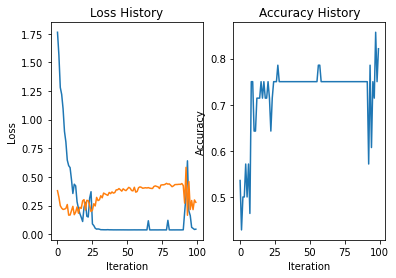

In [65]:
# define neural network
model = WoodNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print_every = 10
train_model(model, optimizer, epochs=100)

In [66]:
# test set accuracy
# comet.ml 
# tqdm 
check_accuracy(loader_test, model)

Got 23 / 28 correct (82.14)


(0.8214285714285714, tensor(0.2780, device='cuda:0'))

## Try getting Pre-trained Model  

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=True)
model.eval()

# if torch.cuda.is_available():
#     train_data = train_data#.to('cuda')
#     model.to('cuda')
for t, data in enumerate(loader_train): 
    with torch.no_grad():
        output = model()
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print(probabilities)

In [ ]:
# import torchvision
# vgg19 = torchvision.models.vgg19(pretrained=True)

# vgg19.classifier[1] = nn.Conv2d(vgg19.classifier[1].in_channels,5,1,1)

from torchvision import datasets, models, transforms
 
squeezenet = models.squeezenet1_1(pretrained=True, progress=True)
# Replace the last layer with one with the correct number of channels
network.load_state_dict
num_ftr = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_ftr, 5, 1, 1)
# squeezenet

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = model.predict(image)

In [ ]:
def test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, n): 
# def test(neutral_faces,smiling_faces,eyesclosed_faces, n): 
    '''
    Function to test that I am able to recontruct the original image with after all the reshaping and shaping.
    Checking the dimensions and shape as well. 
    '''
    print(neutral_faces.shape)

    plt.subplot(1,5,1)
    plt.imshow((neutral_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,2)
    plt.imshow((smiling_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,3)
    plt.imshow((eyesclosed_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,4)
    plt.imshow((surprised_faces[:,n]).reshape((224,224)))
    plt.subplot(1,5,5)
    plt.imshow((sunglasses_faces[:,n]).reshape((224,224)))

# Executing test function        
# test(neutral_faces, smiling_faces, eyesclosed_faces, surprised_faces, sunglasses_faces, 25)  

5/27 to do next:
- need dataloader
- figure out if data is already centered (if not, how to do it for PCA)
- feature extraction (PCA)
- train our ELMAN RNN (link for how to use RNN with Pytorch: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch, https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- find optimal weights
- test
- try out other types of netral networks

Reference* Any publication using this database must reference to this:
- Website: http://tdface.ece.tufts.edu/ and this
- Paper: Panetta, Karen, Qianwen Wan, Sos Agaian, Srijith Rajeev, Shreyas Kamath, Rahul Rajendran, Shishir Rao et al. "A comprehensive database for benchmarking imaging systems." IEEE Transactions on Pattern Analysis and Machine Intelligence (2018).
- R Vemulapalli, A Agarwala, “A Compact Embedding for Facial Expression Similarity”, CoRR, abs/1811.11283, 2018.